In [1]:
import numpy
from netCDF4 import Dataset
import matplotlib.pyplot as mp
import matplotlib.colors as mc
import matplotlib.cm as cm
import mpl_toolkits.mplot3d
import matplotlib
import scipy.ndimage
import datetime

import matplotlib.gridspec

import itertools
import random
import numpy.random
import scipy.stats
import os

mp.rcParams.update({'mathtext.default': 'regular'})

from mpl_toolkits import basemap
import mpl_toolkits.axes_grid1

degree_sign = u'\u00B0'
% matplotlib inline

In [2]:
model_names = numpy.array(( \
'ACCESS1-0', \
'ACCESS1-3', \
'bcc-csm1-1-m', \
'bcc-csm1-1', \
'BNU-ESM', \
'CanESM2', \
'CCSM4', \
'CESM1-BGC', \
'CESM1-CAM5', \
'CMCC-CESM', \
'CMCC-CM', \
'CMCC-CMS', \
'CNRM-CM5', \
'CSIRO-Mk3-6-0', \
'EC-EARTH', \
'FGOALS-g2', \
'GFDL-CM3', \
'GFDL-ESM2G', \
'GFDL-ESM2M', \
'GISS-E2-H', \
'GISS-E2-R', \
'HadGEM2-AO', \
'HadGEM2-CC', \
'HadGEM2-ES', \
'inmcm4', \
'IPSL-CM5A-LR', \
'IPSL-CM5A-MR', \
'IPSL-CM5B-LR', \
'MIROC5', \
'MIROC-ESM-CHEM', \
'MIROC-ESM', \
'MPI-ESM-LR', \
'MPI-ESM-MR', \
'MRI-CGCM3', \
'NorESM1-ME', \
'NorESM1-M' ))
nmods = len(model_names)

In [3]:
pr_lat_lo, pr_lat_hi, pr_lon_lo, pr_lon_hi = 30., 45., 232.5, 248; region = 'CA'
ts_lat_lo, ts_lat_hi, ts_lon_lo, ts_lon_hi = -30., 10., 155., 270.; region = 'tropacific'
ua_lat_lo, ua_lat_hi, ua_lon_lo, ua_lon_hi = 20., 50., 170., 250.; region = 'midlatpacific'

season='djf'; SEASON='DJF'

# Gridspec

In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.axis3d import Axis
import matplotlib.pyplot as plt
import matplotlib.projections as proj
from matplotlib.colors import colorConverter

class axis3d_custom(Axis):
    def __init__(self, adir, v_intervalx, d_intervalx, axes, *args, **kwargs):
        Axis.__init__(self, adir, v_intervalx, d_intervalx, axes, *args, **kwargs)
        self.gridline_colors = []
    def set_gridline_color(self, *gridline_info):
        '''Gridline_info is a tuple containing the value of the gridline to change
        and the color to change it to. A list of tuples may be used with the * operator.'''
        self.gridline_colors.extend(gridline_info)
    def draw(self, renderer):
        # filter locations here so that no extra grid lines are drawn
        Axis.draw(self, renderer)
        which_gridlines = []
        if self.gridline_colors:
            locmin, locmax = self.get_view_interval()
            if locmin > locmax:
                locmin, locmax = locmax, locmin

            # Rudimentary clipping
            majorLocs = [loc for loc in self.major.locator() if
                         locmin <= loc <= locmax]
            for i, val in enumerate(majorLocs):
                for colored_val, color in self.gridline_colors:
                    if val == colored_val:
                        which_gridlines.append((i, color))
            colors = self.gridlines.get_colors()
            for val, color in which_gridlines:
                colors[val] = colorConverter.to_rgba(color)
            self.gridlines.set_color(colors)
            self.gridlines.draw(renderer, project=True)

class XAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.xy_dataLim.intervalx

class YAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.xy_dataLim.intervaly

class ZAxis(axis3d_custom):
    def get_data_interval(self):
        'return the Interval instance for this axis data limits'
        return self.axes.zz_dataLim.intervalx

class Axes3D_custom(Axes3D):
    """
    3D axes object.
    """
    name = '3d_custom'

    def _init_axis(self):
        '''Init 3D axes; overrides creation of regular X/Y axes'''
        self.w_xaxis = XAxis('x', self.xy_viewLim.intervalx,
                            self.xy_dataLim.intervalx, self)
        self.xaxis = self.w_xaxis
        self.w_yaxis = YAxis('y', self.xy_viewLim.intervaly,
                            self.xy_dataLim.intervaly, self)
        self.yaxis = self.w_yaxis
        self.w_zaxis = ZAxis('z', self.zz_viewLim.intervalx,
                            self.zz_dataLim.intervalx, self)
        self.zaxis = self.w_zaxis

        for ax in self.xaxis, self.yaxis, self.zaxis:
            ax.init3d()
proj.projection_registry.register(Axes3D_custom)

# Plot Pareto front info

In [5]:
markersize_small = 10
markersize_verysmall = 3
markersize_big = 20
fontsize=10

xlabel='precip. (mm day$^{-1}$)'
ylabel='SST ($^\circ$C)' #'SST rmse ('+degree_sign+'C)'
zlabel='U200 (m s$^{-1}$)'

fig_titles = ['','(a)','(b)','(c)','(d)']
row_labels = ['$k$=1,2', '$k$=3', '$k$=4', '$k$=5', '$k$=6', '$k$=7']
titles_instances = []

In [33]:
filename_list = numpy.array(( \
'pareto_front_results_2018-05-19_18:13:26_k=1.npy', \
'pareto_front_results_2018-05-19_18:00:38_k=2.npy', \
'pareto_front_results_2018-05-19_18:01:50_k=3.npy', \
'pareto_front_results_2018-05-19_18:02:41_k=4.npy', \
'pareto_front_results_2018-05-19_18:03:35_k=5.npy', \
'pareto_front_results_2018-05-19_15:44:49_NO_LENS_k=6.npy' ))

filename_k7_pareto = 'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_Pareto_fronts.npy'
filename_k7_model_combos = 'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_model_combos.npy'

filename_k7_list_biases = numpy.array(( \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_0-1000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_1000000-2000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_2000000-3000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_3000000-4000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_4000000-5000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_5000000-6000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_6000000-7000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_7000000-8000000.npy', \
'pareto_front_results_2017-07-21_12:51:33_NO_LENS_k=7_partial_8000000-8347680.npy' ))

data_dir = '../../../DATA/subensemble_data/sampling_k_values/'

In [20]:
load_dict = numpy.load(data_dir+filename_list[0])

pareto_set_collect_2d_list = load_dict[()]['pareto_set_collect_2d_list']
pareto_set_collect_3d_list = load_dict[()]['pareto_set_collect_3d_list']

bias_values_subensembles_x = load_dict[()]['bias_values_subensembles_x']
bias_values_subensembles_y = load_dict[()]['bias_values_subensembles_y']
bias_values_subensembles_z = load_dict[()]['bias_values_subensembles_z']

bias_values_subensembles_x_LENS = load_dict[()]['bias_values_subensembles_x_LENS']
bias_values_subensembles_y_LENS = load_dict[()]['bias_values_subensembles_y_LENS']
bias_values_subensembles_z_LENS = load_dict[()]['bias_values_subensembles_z_LENS']

col1_orig = numpy.copy(bias_values_subensembles_x)
col2_orig = numpy.copy(bias_values_subensembles_y)
col3_orig = numpy.copy(bias_values_subensembles_z)

dict_pr = load_dict[()]['dict_x']
dict_ts = load_dict[()]['dict_y']
dict_ua = load_dict[()]['dict_z']

pr_regional_lon_vals = dict_pr['lons']
pr_regional_lat_vals = dict_pr['lats']

N_pareto_loops = 5
model_combinations = load_dict[()]['model_combinations']
k = model_combinations.shape[1]

In [21]:
ncal_latlon = numpy.load('/Users/baird/Dropbox/_analysis/subensembles/NEW_CALCULATIONS/ncal_latlon_array.npy')
ccal_latlon = numpy.load('/Users/baird/Dropbox/_analysis/subensembles/NEW_CALCULATIONS/ccal_latlon_array.npy')
scal_latlon = numpy.load('/Users/baird/Dropbox/_analysis/subensembles/NEW_CALCULATIONS/scal_latlon_array.npy')

In [22]:
# get latlon combo
latlon_indices_ncal = numpy.zeros((ncal_latlon.shape),dtype=int)
latlon_indices_ccal = numpy.zeros((ccal_latlon.shape),dtype=int)
latlon_indices_scal = numpy.zeros((scal_latlon.shape),dtype=int)

for i in range(ncal_latlon.shape[0]):
    latlon_indices_ncal[i,0] = numpy.where(ncal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ncal[i,1] = numpy.where(ncal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_ccal[i,0] = numpy.where(ccal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ccal[i,1] = numpy.where(ccal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_scal[i,0] = numpy.where(scal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_scal[i,1] = numpy.where(scal_latlon[i,1]==dict_pr['lats'])[0][0]

In [23]:
cmip5_hist_pr_ncal = dict_pr['fields_hist_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_hist_pr_ccal = dict_pr['fields_hist_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_hist_pr_scal = dict_pr['fields_hist_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

cmip5_eoc_pr_ncal = dict_pr['fields_eoc_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_eoc_pr_ccal = dict_pr['fields_eoc_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_eoc_pr_scal = dict_pr['fields_eoc_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

In [24]:
# precip indices
pr_indices_lon_ncal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ncal_latlon[i,0]))[0][0] for i in range(ncal_latlon.shape[0]) ]
pr_indices_lat_ncal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ncal_latlon[i,1]))[0][0] for i in range(ncal_latlon.shape[0]) ]

pr_indices_lon_ccal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, ccal_latlon[i,0]))[0][0] for i in range(ccal_latlon.shape[0]) ]
pr_indices_lat_ccal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, ccal_latlon[i,1]))[0][0] for i in range(ccal_latlon.shape[0]) ]

pr_indices_lon_scal = [ numpy.where(numpy.in1d(pr_regional_lon_vals, scal_latlon[i,0]))[0][0] for i in range(scal_latlon.shape[0]) ]
pr_indices_lat_scal = [ numpy.where(numpy.in1d(pr_regional_lat_vals, scal_latlon[i,1]))[0][0] for i in range(scal_latlon.shape[0]) ]

In [25]:
# loop through the optimal subensembles
# pull out ccal, ncal, scal lat/lon indices, take average
# look at them

# get latlon combo
latlon_indices_ncal = numpy.zeros((ncal_latlon.shape),dtype=int)
latlon_indices_ccal = numpy.zeros((ccal_latlon.shape),dtype=int)
latlon_indices_scal = numpy.zeros((scal_latlon.shape),dtype=int)

for i in range(ncal_latlon.shape[0]):
    latlon_indices_ncal[i,0] = numpy.where(ncal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ncal[i,1] = numpy.where(ncal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_ccal[i,0] = numpy.where(ccal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_ccal[i,1] = numpy.where(ccal_latlon[i,1]==dict_pr['lats'])[0][0]

    latlon_indices_scal[i,0] = numpy.where(scal_latlon[i,0]==dict_pr['lons'])[0][0]
    latlon_indices_scal[i,1] = numpy.where(scal_latlon[i,1]==dict_pr['lats'])[0][0]

In [26]:
# individual models
model_delta_pr_ncal = numpy.zeros(nmods)
model_delta_pr_ccal = numpy.zeros(nmods)
model_delta_pr_scal = numpy.zeros(nmods)

for i in range(nmods):
    hist = numpy.mean(dict_pr['fields_hist_mods'][i,pr_indices_lat_ncal,pr_indices_lon_ncal])
    eoc = numpy.mean(dict_pr['fields_eoc_mods'][i,pr_indices_lat_ncal,pr_indices_lon_ncal])
    model_delta_pr_ncal[i] = eoc-hist

    hist = numpy.mean(dict_pr['fields_hist_mods'][i,pr_indices_lat_ccal,pr_indices_lon_ccal])
    eoc = numpy.mean(dict_pr['fields_eoc_mods'][i,pr_indices_lat_ccal,pr_indices_lon_ccal])
    model_delta_pr_ccal[i] = eoc-hist

    hist = numpy.mean(dict_pr['fields_hist_mods'][i,pr_indices_lat_scal,pr_indices_lon_scal])
    eoc = numpy.mean(dict_pr['fields_eoc_mods'][i,pr_indices_lat_scal,pr_indices_lon_scal])
    model_delta_pr_scal[i] = eoc-hist

# Calculate California index information

In [27]:
cmip5_hist_pr_ncal = dict_pr['fields_hist_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_hist_pr_ccal = dict_pr['fields_hist_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_hist_pr_scal = dict_pr['fields_hist_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

cmip5_eoc_pr_ncal = dict_pr['fields_eoc_mods'][:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
cmip5_eoc_pr_ccal = dict_pr['fields_eoc_mods'][:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
cmip5_eoc_pr_scal = dict_pr['fields_eoc_mods'][:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

# Collect Pareto-optimal subensemble information

In [28]:
lo_perc = 10
hi_perc = 90
med_perc = 50

In [29]:
hi_idx_PO_list = []
median_idx_PO_list = []
lo_idx_PO_list = []

In [30]:
flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
medianprops = dict(linewidth=2, color='firebrick')
boxprops = dict(linewidth=2, color='0.1')
whiskerprops = dict(linewidth=2, color='0.1')
capprops = dict(linewidth=2, color='0.1')

(73, 2)
(254, 3)
(534, 4)
(931, 5)
(1328, 6)
(1848, 7)


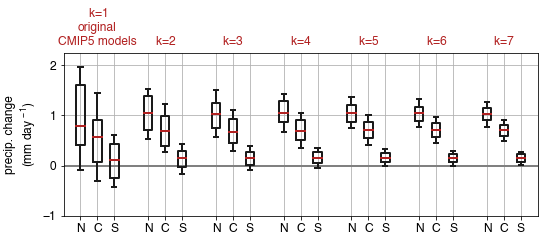

In [34]:
k_values = [0,1,2,3] # should always be AT LEAST [0]

fontsize=12

fig = mp.figure(figsize=(8.5,3))
ax = fig.add_subplot(111)

ax.axhline(0,lw=2,c='0.5', zorder=1)
boxplot_width=[0.5]

for k_idx in [0,1,2,3,4,5,6]:#range(filename_list.size):

    whisk_range = [lo_perc, hi_perc]

    if k_idx==0:
        ax.boxplot(model_delta_pr_ncal, zorder=2, positions=[1.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.boxplot(model_delta_pr_ccal, zorder=2, positions=[2.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.boxplot(model_delta_pr_scal, zorder=2, positions=[3.0], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

        ax.text(s='$k$=1\noriginal\nCMIP5 models', x=2.0, y=2.35, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

        flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
        medianprops = dict(linewidth=2, color='firebrick')
        boxprops = dict(linewidth=2, color='0.1')
        whiskerprops = dict(linewidth=2, color='0.1')
        capprops = dict(linewidth=2, color='0.1')

    elif k_idx>0:
        
        if k_idx<6: 
            load_dict = numpy.load(data_dir+filename_list[k_idx])
            pareto_set_collect_3d_list = load_dict[()]['pareto_set_collect_3d_list']
            bias_values_subensembles_x = load_dict[()]['bias_values_subensembles_x']
            bias_values_subensembles_y = load_dict[()]['bias_values_subensembles_y']
            bias_values_subensembles_z = load_dict[()]['bias_values_subensembles_z']
            col1_orig = numpy.copy(bias_values_subensembles_x)
            col2_orig = numpy.copy(bias_values_subensembles_y)
            col3_orig = numpy.copy(bias_values_subensembles_z)
            model_combinations = load_dict[()]['model_combinations']
            k = model_combinations.shape[1]
        
        else: # when k_idx==6, then k=7
            
            bias_values_subensembles_x = numpy.empty((0))
            bias_values_subensembles_y = numpy.empty((0))
            bias_values_subensembles_z = numpy.empty((0))

            for i in range(filename_k7_list_biases.size):

                load_dict = numpy.load(data_dir+filename_k7_list_biases[i])

                bias_values_subensembles_x = numpy.append(bias_values_subensembles_x, load_dict[()]['bias_values_subensembles_x'])
                bias_values_subensembles_y = numpy.append(bias_values_subensembles_y, load_dict[()]['bias_values_subensembles_y'])
                bias_values_subensembles_z = numpy.append(bias_values_subensembles_z, load_dict[()]['bias_values_subensembles_z'])
                
            col1_orig = numpy.copy(bias_values_subensembles_x)
            col2_orig = numpy.copy(bias_values_subensembles_y)
            col3_orig = numpy.copy(bias_values_subensembles_z)
            
            load_dict = numpy.load(data_dir+filename_k7_pareto)
            pareto_set_collect_3d_list = load_dict[()]['pareto_set_collect_3d_list']

            load_dict = numpy.load(data_dir+filename_k7_model_combos)
            model_combinations = load_dict[()]['model_combinations']
            k = model_combinations.shape[1]

        # now get all the subensembles in pareto_set_collect, take their mean, and look at end-of-century precip change
        # GET INFO ON OPTIMAL PARETO SETS, ETC.

        pareto_set_collect = pareto_set_collect_3d_list[0]

        # SAVE THE MODELS THAT MAKE UP THE PARETO FRONT
        n_optima = pareto_set_collect.shape[0]
        optimal_subensembles = numpy.empty((n_optima, k), dtype=object)
        optimal_subensembles_indices = numpy.empty((n_optima, k), dtype=int)

        optimal_y_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)
        optimal_x_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)
        optimal_z_subensembles = numpy.empty((N_pareto_loops, k), dtype=object)

        optimal_y_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)
        optimal_x_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)
        optimal_z_pareto_combos = numpy.zeros(N_pareto_loops, dtype=numpy.int)

        for i in range(n_optima):
            pareto_combo = numpy.where((col1_orig==pareto_set_collect[i,0]) & (col2_orig==pareto_set_collect[i,1]) & (col3_orig==pareto_set_collect[i,2]))[0][0]
            optimal_subensembles[i,:] = model_names[model_combinations[pareto_combo,:]]
            optimal_subensembles_indices[i,:] = model_combinations[pareto_combo,:]

        optimal_subensembles = optimal_subensembles.astype(numpy.str)

        print(optimal_subensembles.shape)
        # calculate precip change over each optimal subensemble
        all_po_subensembles_hist = numpy.zeros((optimal_subensembles.shape[0], dict_pr['nlat'], dict_pr['nlon']))
        all_po_subensembles_eoc = numpy.zeros((optimal_subensembles.shape[0], dict_pr['nlat'], dict_pr['nlon']))
        individual_subensembles_hist = numpy.zeros((k, dict_pr['nlat'], dict_pr['nlon']))
        individual_subensembles_eoc = numpy.zeros((k, dict_pr['nlat'], dict_pr['nlon']))
        for ens in range(optimal_subensembles.shape[0]):
            for member in range(k):
                individual_subensembles_hist[member,:,:] = dict_pr['fields_hist_mods'][numpy.where(optimal_subensembles[ens,member]==model_names)[0][0],:,:]
                individual_subensembles_eoc[member,:,:] = dict_pr['fields_eoc_mods'][numpy.where(optimal_subensembles[ens,member]==model_names)[0][0],:,:]
            all_po_subensembles_hist[ens,:,:] = numpy.mean(individual_subensembles_hist, axis=0)
            all_po_subensembles_eoc[ens,:,:] = numpy.mean(individual_subensembles_eoc, axis=0)

        # pull out all subensembles
        all_po_subensembles_hist_ncal = all_po_subensembles_hist[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
        all_po_subensembles_hist_ccal = all_po_subensembles_hist[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
        all_po_subensembles_hist_scal = all_po_subensembles_hist[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

        all_po_subensembles_eoc_ncal = all_po_subensembles_eoc[:,latlon_indices_ncal[:,1],latlon_indices_ncal[:,0]].mean(axis=1)
        all_po_subensembles_eoc_ccal = all_po_subensembles_eoc[:,latlon_indices_ccal[:,1],latlon_indices_ccal[:,0]].mean(axis=1)
        all_po_subensembles_eoc_scal = all_po_subensembles_eoc[:,latlon_indices_scal[:,1],latlon_indices_scal[:,0]].mean(axis=1)

        all_po_subensembles_hist_ncal_mean = numpy.mean(all_po_subensembles_hist_ncal, axis=0)
        all_po_subensembles_hist_ccal_mean = numpy.mean(all_po_subensembles_hist_ccal, axis=0)
        all_po_subensembles_hist_scal_mean = numpy.mean(all_po_subensembles_hist_scal, axis=0)


        # individual models
        model_delta_pr_ncal = numpy.zeros(nmods)
        model_delta_pr_ccal = numpy.zeros(nmods)
        model_delta_pr_scal = numpy.zeros(nmods)
        #model_delta_pr_coastal_cal = numpy.zeros((nmods,5))

        for i in range(nmods):
            hist = cmip5_hist_pr_ncal[i]
            eoc = cmip5_eoc_pr_ncal[i]
            model_delta_pr_ncal[i] = eoc-hist

            hist = cmip5_hist_pr_ccal[i]
            eoc = cmip5_eoc_pr_ccal[i]
            model_delta_pr_ccal[i] = eoc-hist

            hist = cmip5_hist_pr_scal[i]
            eoc = cmip5_eoc_pr_scal[i]
            model_delta_pr_scal[i] = eoc-hist

        optimal_subensembles_delta_pr_ncal = numpy.zeros(optimal_subensembles.shape[0])
        optimal_subensembles_delta_pr_ccal = numpy.zeros(optimal_subensembles.shape[0])
        optimal_subensembles_delta_pr_scal = numpy.zeros(optimal_subensembles.shape[0])
        #optimal_subensembles_delta_pr_coastal_cal = numpy.zeros((optimal_subensembles.shape[0],5))

        for i in range(optimal_subensembles.shape[0]):
            hist = all_po_subensembles_hist_ncal[i]
            eoc = all_po_subensembles_eoc_ncal[i]
            optimal_subensembles_delta_pr_ncal[i] = eoc-hist

            hist = all_po_subensembles_hist_ccal[i]
            eoc = all_po_subensembles_eoc_ccal[i]
            optimal_subensembles_delta_pr_ccal[i] = eoc-hist

            hist = all_po_subensembles_hist_scal[i]
            eoc = all_po_subensembles_eoc_scal[i]
            optimal_subensembles_delta_pr_scal[i] = eoc-hist

            distro = optimal_subensembles_delta_pr_ccal
            lo_idx_PO = numpy.where(distro==numpy.percentile(distro, lo_perc, interpolation='nearest'))[0][0]
            hi_idx_PO = numpy.where(distro==numpy.percentile(distro, hi_perc, interpolation='nearest'))[0][0]
            median_idx_PO = numpy.where(distro==numpy.percentile(distro, med_perc, interpolation='nearest'))[0][0]

        field_list = [lo_idx_PO, median_idx_PO, hi_idx_PO]

        flierprops = dict(marker='.', markeredgecolor='0.1', markerfacecolor='0.1')
        medianprops = dict(linewidth=2, color='firebrick')
        boxprops = dict(linewidth=2, color='0.1')
        whiskerprops = dict(linewidth=2, color='0.1')
        capprops = dict(linewidth=2, color='0.1')


        ax.boxplot(optimal_subensembles_delta_pr_ncal, zorder=2, positions=[k_idx*4+1], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.boxplot(optimal_subensembles_delta_pr_ccal, zorder=2, positions=[k_idx*4+2], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)
        ax.boxplot(optimal_subensembles_delta_pr_scal, zorder=2, positions=[k_idx*4+3], whis=whisk_range, showfliers=False, widths=boxplot_width, flierprops=flierprops, medianprops=medianprops, boxprops=boxprops, whiskerprops=whiskerprops, capprops=capprops)

        ax.text(s='$k$='+str(k_idx+1), x=k_idx*4+2, y=2.35, fontsize=fontsize, ha='center', va='bottom', color='firebrick')

ax.set_xlim(0,7*4)
ax.set_ylim(-0.6,2.25)
ax.tick_params(labelsize=fontsize)
ax.set_ylabel('precip. change\n(mm day$^{\, -1}$)', fontsize=fontsize)
ax.set_xticklabels(['N','C','S']*7)
ax.set_xticks([1,2,3, 5,6,7, 9,10,11, 13,14,15, 17,18,19, 21,22,23, 25,26,27])
ax.set_yticks([-1,0,1,2])#,2])
ax.grid()
ax.set_axisbelow(True)

fig.savefig('SI_figure_k1to7_box_and_whisker.pdf', bbox_inches='tight', transparent=True)